In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class VRPTW:
    def __init__(
        self,
        population_size,
        dimensions,
        bounds,
        Mutation_rate,
        Crossover_rate,
        
        ### Add
        island,
        migration_rate,
        ### 
        distance,
        ### Add
        demand,
        readyTime,
        dueDate,
        serviceTime,
        vehicle
        ###
    ):
        # Input params
        self.population_size = population_size
        self.dimensions = dimensions
        self.bounds = bounds
        self.Mutation_rate = Mutation_rate
        self.Crossover_rate = Crossover_rate
        
        ### Add
        self.island = island
        self.migration_rate = migration_rate
        ###
        self.distance = distance
        ### Add
        self.demand = demand
        self.readyTime = readyTime
        self.dueDate = dueDate 
        self.serviceTime = serviceTime
        self.vehicle = vehicle
        ###

        # Internal params
        self.global_solution = np.array([])
        self.F = Mutation_rate[0]
        self.CR = Crossover_rate[0]
        ### Add
        self.migration_cost = np.array([])
        self.current_cost = np.array([])
        ###
        self.kwargs = {
                    "distance": distance,
                    ### Add
                    "demand": demand,
                    "readyTime": readyTime,
                    "dueDate": dueDate,
                    "serviceTime": serviceTime,
                    "vehicle": vehicle,}
                    ###
    
        # Derived internal
        self.population = None
        self.Upperbound_Mutation = None
        self.Lowerbound_Mutation = None
        self.Upperbound_Crossover_rate = None
        self.Lowerbound_Crossover_rate = None
        ### Add
        #self.migration_rate = None
        #self.island = None
        ###
        
        
    def reset(self):
        # Initialize population
        self.population = np.random.uniform(
            self.bounds[:, 0],
            self.bounds[:, 1],
            (self.population_size, len(self.bounds)),
        )
        self.Upperbound_Mutation = self.Mutation_rate[1]
        self.Lowerbound_Mutation = self.Mutation_rate[0]
        self.Upperbound_Crossover_rate = self.Crossover_rate[1]
        self.Lowerbound_Crossover_rate = self.Crossover_rate[0]
        self.F = self.Mutation_rate[0]
        self.CR = self.Crossover_rate[0]
        ### Add
        self.island = self.island
        self.migration_rate = self.migration_rate
        ###
        

    def preserving_strategy(self, X, V, **kwargs):
        # --- Unpack input data from keyword arguments ---
        dist = kwargs["distance"]  # Distance/time matrix between all nodes
        weight = kwargs["demand"]  # Demand (weight) for each customer node
        ready = kwargs["readyTime"]  # Ready time (earliest service time) for each node
        due = kwargs["dueDate"]  # Due time (latest service time) for each node
        service = kwargs["serviceTime"]  # Service time at each node
        vehicle = kwargs[
            "vehicle"
        ]  # Vehicle info: [number of vehicles, capacity per vehicle]
        # Get per-vehicle capacities (by indexing with V)
        pre_w_cap = np.array([vehicle[1]] * vehicle[0])
        w_cap = pre_w_cap[V]

        # -- Initialization --
        sequence = X  # Route sequence (includes depot at start & end)
        n_cust = len(sequence) - 2  # Number of customers (not counting depot nodes)
        n_veh = vehicle[0] - 1  # Number of vehicles - 1 (for indexing)
        i, k = 0, 0  # i: current position in sequence, k: vehicle index
        total_distance = 0  # Store total traveled distance (with penalty if any)

        # -- Main loop over each vehicle route --
        while k <= n_veh and i <= n_cust:
            # Initialize per-route accumulators
            route_dist, route_time, weight_load, penaltyCost = 0, 0, 0, 0

            if k > 0:
                i += 1  # Move to the next start customer for the next vehicle
            # Start route: depot to first customer
            route_dist += dist[0][sequence[i]]  # Distance depot -> first customer
            route_time += (
                service[0] + dist[0][sequence[i]]
            )  # Service + travel time to first customer
            weight_load += weight[sequence[i]]  # Initial cargo: first customer demand

            if route_time < ready[sequence[i]]:
                route_time = ready[sequence[i]]  # Wait if vehicle arrives before ready time

            if route_time > due[sequence[i]] or weight_load > w_cap[k]:
                penaltyCost += 1e11  # Penalty: arrived after due time (infeasible)
                break

            # --- Continue visiting customers along this route ---
            while i <= n_cust:
                route_dist += dist[sequence[i]][sequence[i + 1]]  # Add next leg distance
                route_time += (
                    service[sequence[i]] + dist[sequence[i]][sequence[i + 1]]
                )  # Add service + travel time
                weight_load += weight[sequence[i + 1]]  # Add new customer demand

                if route_time < ready[sequence[i + 1]]:
                    route_time = ready[sequence[i + 1]]  # Wait if arrive early at next node

                # If time window or capacity violated, backtrack and finish route
                if route_time > due[sequence[i + 1]] or weight_load > w_cap[k]:
                    route_dist -= dist[sequence[i]][sequence[i + 1]]
                    route_time -= service[sequence[i]] + dist[sequence[i]][sequence[i + 1]]
                    weight_load -= weight[sequence[i + 1]]
                    break
                i += 1

            # --- Finish by returning to depot ---
            route_dist += dist[sequence[i]][0]  # Add distance to depot
            route_time += (
                service[sequence[i]] + dist[sequence[i]][0]
            )  # Add service at last node + travel to depot
            if route_time > due[0]:
                penaltyCost += 1e11  # Penalty: returned to depot too late
            # Accumulate this route's total (distance + penalty if any)
            total_distance += route_dist + penaltyCost
            k += 1  # Next vehicle

        return (
            total_distance  # Return overall objective (distance with penalty if violated)
        )

    def f_per_particle(self, m, s, **kwargs):
        X = m  # Sequence
        V = s  # Vehicle
        obj_val = self.preserving_strategy(X, V, **kwargs)  # Call Preserving strategy.
        return obj_val

    def objective_func(self, x, **kwargs):
        vehicle = kwargs["vehicle"]
        seq = x[: -vehicle[0]].argsort() + 1
        sort = x[-vehicle[0]:].argsort() 
        j = self.f_per_particle(seq, sort, **kwargs)
        return np.array(j)
    
    
    def evolve(self, n_iteration, island):
        
        for num_island in range(island):
            
            ### Add
            Upperbound_Mutation = self.Upperbound_Mutation
            Lowerbound_Mutation = self.Lowerbound_Mutation
            Upperbound_Crossover_rate = self.Upperbound_Crossover_rate
            Lowerbound_Crossover_rate = self.Lowerbound_Crossover_rate
            population_size = self.population_size
            bounds = self.bounds
            max_generations = n_iteration
            ###
            ### Add
            migration_rate = self.migration_rate
            ###            
            """ if num_island == 0:
                # Initialize population
                self.population = np.random.uniform(
                    bounds[:, 0], bounds[:, 1], (population_size, len(bounds))
                )
                
            else: """
            if num_island > 0:    
                # Initialize population
                self.population = np.random.uniform(
                    bounds[:, 0], bounds[:, 1], (population_size, len(bounds))
                )
                migration_cost = np.array([])
                for obj in range(population_size):
                    migration_cost = np.insert(
                        migration_cost,
                        len(migration_cost),
                        self.objective_func(self.population[obj], **self.kwargs),
                    )

                idx_good_migration = migration_cost.argsort()
                idx_bad_migration = np.flip(idx_good_migration)[
                    : int(population_size * migration_rate)
                ]

                self.population[idx_bad_migration] = migration_population
            ###
    
            for _ in range(max_generations):
                # print(f'Iteration {generation}')
                current_cost = np.array([])
                self.F += (Upperbound_Mutation - Lowerbound_Mutation) / max_generations
                self.CR += (
                    Upperbound_Crossover_rate - Lowerbound_Crossover_rate
                ) / max_generations
                
                
                for i in range(population_size):
                    # Mutation
                    indices = [idx for idx in range(population_size) if idx != i]
                    a, b, c = self.population[np.random.choice(indices, 3, replace=False)]
                    mutant = self.population[i] + self.F * (b - c)

                    # Crossover
                    crossover_prob = np.random.rand(len(bounds))
                    trial = np.where(crossover_prob < self.CR, mutant, self.population[i])

                    # Selection
                    fitness_trial = self.objective_func(trial, **self.kwargs)
                    fitness_current = self.objective_func(self.population[i], **self.kwargs)

                    if fitness_trial < fitness_current:
                        self.population[i] = trial
                        current_cost = np.insert(
                            current_cost, len(current_cost), fitness_trial
                        )
                    else:
                        current_cost = np.insert(
                            current_cost, len(current_cost), fitness_current
                        )
                ### Add        
                idx_best_migration = current_cost.argsort()[
                            : int(population_size * migration_rate)
                        ]
                migration_population = self.population[idx_best_migration]
                ### 
                
                best_index_plot = current_cost[np.argmin(current_cost)]
                self.global_solution = np.insert(
                    self.global_solution, len(self.global_solution), best_index_plot
                )
                
                
                
            # Find the best solution
            best_index = np.argmin(
                [
                    self.objective_func(individual, **self.kwargs)
                    for individual in self.population
                ]
            )
            best_solution = self.population[best_index]

        return best_solution, self.global_solution
    
    
    
    def get_best_solution(self):
        # Evaluate the objective value for each individual in the population.
        obj_values = [self.objective_func(ind, **self.kwargs) for ind in self.population]

        # Find the index of the individual with the lowest (best) objective value.
        best_index = np.argmin(obj_values)

        # Get the best objective value and the corresponding individual (solution).
        best_solution = obj_values[best_index]
        best_position = self.population[best_index]
        
        #return best_solution, best_position
        # Note  : for some reason, the best_solution has zero dimension. I need to convert to float.
        return best_solution.flatten()[0]

        

In [ ]:
def compute_euclidean_distance_matrix(locations):
    """
    Compute Euclidean distance matrix for a list of locations.
    Args:
        locations: numpy array or list of shape (N, 2), with [x, y] coordinates for each node (depot + customers)
    Returns:
        distance_matrix: numpy array of shape (N, N) where (i, j) is the distance between node i and j
    """
    locations = np.array(locations)
    diff = locations[:, np.newaxis, :] - locations[np.newaxis, :, :]
    distance_matrix = np.sqrt(np.sum(diff**2, axis=-1))
    return distance_matrix


# Load CSV files
df_customers = pd.read_excel(
    r"C:\rl-meta-test\src\Source\Solomon datasets\c101.xlsx", sheet_name="customer"
)
df_dataInfo = pd.read_excel(
    r"C:\rl-meta-test\src\Source\Solomon datasets\c101.xlsx", sheet_name="vehicle"
)


#customer = 10

# Extract coordinates (x, y) of customers (including depot) and convert to NumPy array
xycoord = df_customers.iloc[:, 1:3].to_numpy()
distance = compute_euclidean_distance_matrix(xycoord)  # Calculate distance
# distance = pd.read_csv(
#    r"C:\rl-meta-test\src\Source\solomon_data\solomon25_csv\distance_matrix\c101distanceMatrix.csv"
# ).to_numpy()


# Extract demand for each customer as NumPy array
demand = df_customers.iloc[:, 3].to_numpy()

# Extract 'ready time' (earliest time service can begin at each customer)
readyTime = df_customers.iloc[:, 4].to_numpy()

# Extract 'due date' (latest time service must begin at each customer)
dueDate = df_customers.iloc[:, 5].to_numpy()

# Extract service time required at each customer
serviceTime = df_customers.iloc[:, 6].to_numpy()

# Extract vehicle information (such as capacity, number of vehicles, etc.) from the first row of df_dataInfo
vehicle = df_dataInfo.iloc[0, :].to_numpy()

kwargs = {
    "distance": distance,
    "demand": demand,
    "readyTime": readyTime,
    "dueDate": dueDate,
    "serviceTime": serviceTime,
    "vehicle": vehicle,
}

dimensions = len(distance) - 1 + vehicle[0]
maxiters = 1000
population_size = 100
bounds = np.array([[0, 1]] * dimensions)

Mutation_rate = 0.5
Crossover_rate = 0.5

island = 15
migration_rate = 0.5

vrptw = VRPTW(
    population_size=population_size,
    dimensions=dimensions,
    bounds=bounds,
    Mutation_rate=Mutation_rate,
    Crossover_rate=Crossover_rate,
    island=island,
    migration_rate=migration_rate,
    distance=distance,
    demand=demand,
    readyTime=readyTime,
    dueDate=dueDate,
    serviceTime=serviceTime,
    vehicle=vehicle 
)

In [4]:
vrptw.reset()
best_solution, global_solution_plot = vrptw.evolve(n_iteration=maxiters, island=island)

In [5]:
global_solution_plot[-1]

np.float64(1040.3253435945157)

In [6]:
vrptw.get_best_solution()

np.float64(1040.3253435945157)

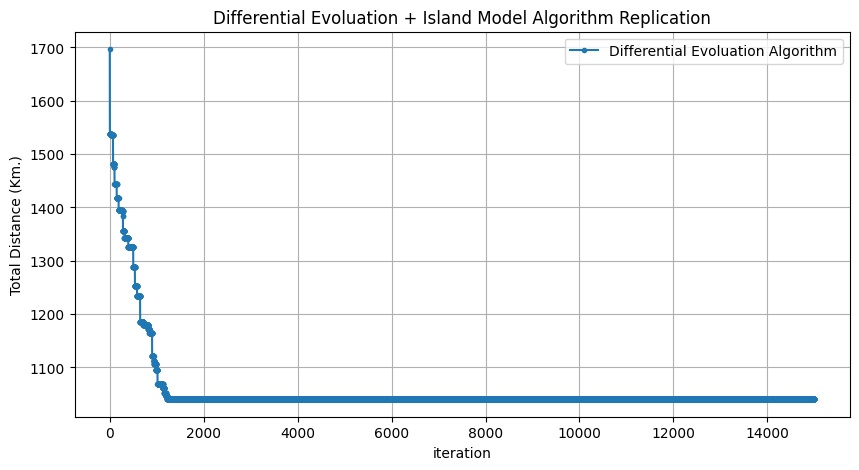

In [7]:
Replication = [i for i in range(len(global_solution_plot))]
y1 = global_solution_plot.tolist()
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(Replication, y1, marker=".", label="Differential Evoluation Algorithm")
ax.set(
    xlabel="iteration",
    ylabel="Total Distance (Km.)",
    title="Differential Evoluation + Island Model Algorithm Replication",
)
ax.grid()
ax.legend()
plt.show()